#### Synthea

##### Process

In [304]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import classification_report

import sys
sys.path.insert(1, '../')
from utils.packages import *

def load_model(path, model):
    # load pretrained model and update weights
    pretrained_dict = torch.load(path)
    model_dict = model.state_dict()
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    # 3. load the new state dict
    model.load_state_dict(model_dict)
    return model

global_params = {
    'max_seq_len': 64,
    'gradient_accumulation_steps': 1
}

optim_param = {
    'lr': 3e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

train_params = {
    'batch_size': 10,
    'use_cuda': True,
    'max_len_seq': global_params['max_seq_len'],
    'device': 'cuda' #change this to run on cuda #'cuda:0'
}

dataset_name = 'Synthea/Small_cohorts/'

feature_types = {'diagnosis':True, 'medications':False, 'procedures':False}

if (feature_types['diagnosis'] and feature_types['medications']):
    print("Do only use diagnosis")
    code_voc = 'MLM_diagnosmedcodes.npy'
    age_voc = 'MLM_age.npy'

elif (feature_types['diagnosis'] and not feature_types['medications']):
    code_voc = 'MLM_diagnoscodes.npy'
    age_voc = 'MLM_age.npy'

else:
    code_voc = 'MLM_diagnosmedproccodes.npy'
    age_voc = 'MLM_age.npy'

files = {'code':'../data/vocabularies/' + dataset_name + code_voc,
             'age':'../data/vocabularies/' + dataset_name + age_voc,
        }

tokenizer = EHRTokenizer(task='MLM', filenames=files)

model_config = {
        'vocab_size': len(tokenizer.getVoc('code').keys()), # number of disease + symbols for word embedding
        'hidden_size': 288, #tune.choice([100, 150, 288]), #288, # word embedding and seg embedding hidden size
        'seg_vocab_size': 2, # number of vocab for seg embedding
        'age_vocab_size': len(tokenizer.getVoc('age').keys()), # number of vocab for age embedding,
        'gender_vocab_size': 3,
        'max_position_embeddings': train_params['max_len_seq'], # maximum number of tokens
        'hidden_dropout_prob': 0.1, # dropout rate
        'num_hidden_layers': 6, #4, # number of multi-head attention layers required
        'num_attention_heads': 12, # number of attention heads
        'attention_probs_dropout_prob': 0.1, # multi-head attention dropout rate
        'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
        'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
        'initializer_range': 0.02, # parameter weight initializer range
        'use_prior':False,
        'reg':0.1,
        'age':True,
        'gender':False,
        'epochs':20,
    }

stats_path = '../data/datasets/Synthea/Small_cohorts/train_stats/'
condfiles = {'dd':stats_path + 'dd_cond_probs.empirical.p', 
             'dp':stats_path + 'dp_cond_probs.empirical.p',
             'dm':stats_path + 'dm_cond_probs.empirical.p',
             'pp':stats_path + 'pp_cond_probs.empirical.p', 
             'pd':stats_path + 'pd_cond_probs.empirical.p',
             'pm':stats_path + 'pd_cond_probs.empirical.p',
             'mm':stats_path + 'mm_cond_probs.empirical.p', 
             'md':stats_path + 'md_cond_probs.empirical.p',
             'mp':stats_path + 'mp_cond_probs.empirical.p',
            }

In [305]:
path='../data/datasets/' + dataset_name
path

'../data/datasets/Synthea/Small_cohorts/'

In [306]:
train = pd.read_parquet(path + 'train.parquet')
val = pd.read_parquet(path + 'val.parquet')
test = pd.read_parquet(path + 'test.parquet')
all_data = pd.concat([train, val, test])

In [307]:
mapdata = pd.read_csv('../data/mapping_data/Synthea/unique_conds.csv')
mapdata['CODE'] = mapdata['CODE'].map(str)
code_to_desc = dict(zip(mapdata.CODE,mapdata.DESCRIPTION))

In [308]:
hypertensioncode = int(mapdata[mapdata['DESCRIPTION'].isin(['Hypertension', 'hypertension'])]['CODE'].iloc[0])
all_data['diagnos_flatten'] = all_data['diagnos_code'].apply(lambda x: np.concatenate(x))
all_data['hypercode'] = all_data['diagnos_flatten'].apply(lambda x: True if hypertensioncode in x else False)
hypertensionpatients = all_data[all_data['hypercode'] == True]

In [309]:
folderpath = '../data/pytorch_datasets/' + dataset_name
hypertensionpatientsdataset = EHRDataset(hypertensionpatients, max_len=train_params['max_len_seq'], run_type='Hypertension_patients', save_folder=folderpath,feature_types=feature_types, conditional_files=condfiles, tokenizer=tokenizer)
hypertensionloader = torch.utils.data.DataLoader(hypertensionpatientsdataset, batch_size=1, pin_memory=True, shuffle=True)

Loading data


In [310]:
conf = BertConfig(model_config)
model = BertForMaskedLM(conf)
PATH = "../saved_models/MLM/BEHRT_Synthea"
model = load_model(PATH, model)
params = list(model.named_parameters())
optim = adam(params, optim_param)

t_total value of -1 results in schedule not being applied


##### Attention

###### Example

In [311]:
iterr = iter(hypertensionloader)

In [318]:
with torch.no_grad():
    model.eval()
    datapoint = next(iterr)
    age, gender, code, position, segment, mask, label, prior_guide, tokens = datapoint

    loss, preds, labels, attention_scores, sequence_outputs = model(code, age_ids=age, gender_ids=gender, seg_ids=segment, posi_ids=position, attention_mask=mask, labels=label, prior_guide=prior_guide)
    sentence = tokenizer.convert_ids_to_tokens(tokens.numpy().squeeze(), 'code')
    lastatt = attention_scores[-1]
    averagedlastatt = ((lastatt.sum(dim=1) / lastatt.shape[1])[0]).detach().numpy()

In [340]:
lastatt = attention_scores[-1]

<Figure size 720x1080 with 0 Axes>

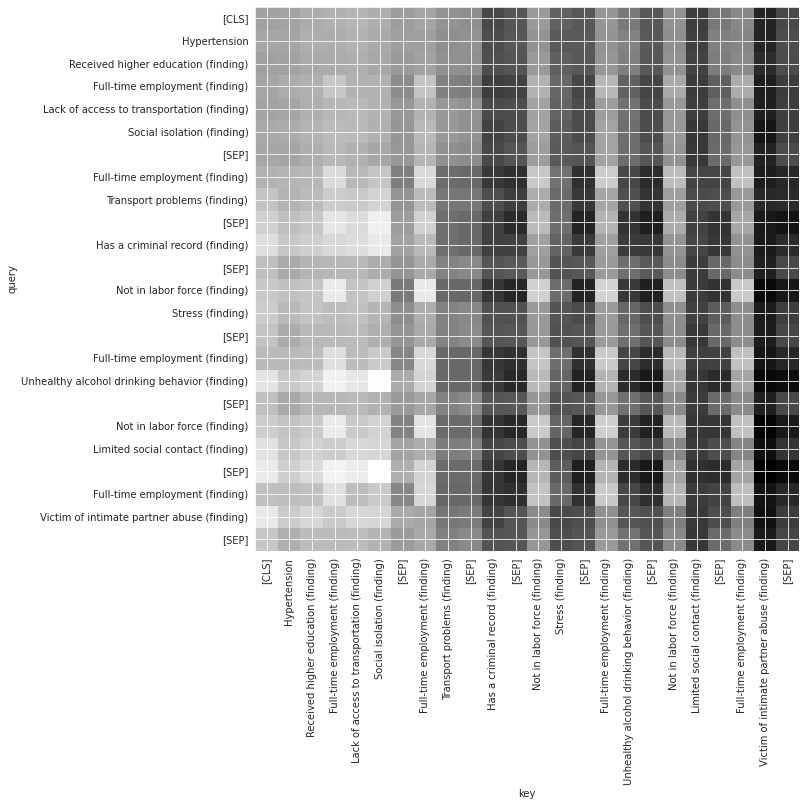

In [341]:
sentence = [code_to_desc[s] if s in code_to_desc else s for s in sentence if s!='[PAD]']
f, ax = plt.subplots(figsize = (10,15))
map1 = lastatt[0][1].detach().numpy() #((layer.sum(dim=1) / layer.shape[1])[0]).detach().numpy()
map1 = map1[:len(sentence), :len(sentence)]
#print(map1)
plt.clf()
f=plt.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
i=ax.imshow(map1,interpolation='nearest',cmap='gray')
ax.set_yticks(range(len(sentence)))
ax.set_yticklabels(sentence, fontsize=10)
ax.set_xticks(range(len(sentence)))
ax.set_xticklabels(sentence,rotation=90, fontsize=10)
ax.set_xlabel('key', fontsize=10)
ax.set_ylabel('query', fontsize=10)
ax.grid(linewidth = 0.8)

###### Average

In [253]:
token_combs = {}
with torch.no_grad():
    model.eval()
    for idx, batch in enumerate(hypertensionloader):
        if idx == 5000:
            break
        age, gender, code, position, segment, mask, label, prior_guide, tokens = batch
        loss, preds, labels, attention_scores, sequence_outputs = model(code, age_ids=age, gender_ids=gender, seg_ids=segment, posi_ids=position, attention_mask=mask, labels=label, prior_guide=prior_guide)
        sentence = tokenizer.convert_ids_to_tokens(tokens.numpy().squeeze(), 'code')
        #sentences.extend(sentence)
        seq_out = sequence_outputs[-1]
        lastattentionscores = attention_scores[-1]
        
        averagedheads = (lastattentionscores.sum(dim=1) / lastattentionscores.shape[1])[0]
        
        dontlookattokens = set(['[CLS]', '[SEP]', '[PAD]'])
        for idx1, token1 in enumerate(sentence):
            if token1 in dontlookattokens:
                continue
            for idx2, token2 in enumerate(sentence):
                if token2 in dontlookattokens:
                    continue
                comb = token1 + ',' + token2
                prob = averagedheads[idx1, idx2]
                if comb not in token_combs:
                    token_combs[comb] = (prob.item(), 1)
                else:
                    new_prob = prob.item() + token_combs[comb][0]
                    numtimes = token_combs[comb][1] + 1
                    token_combs[comb] = (new_prob, numtimes)
        #seq = torch.cat((seq, seq_out), 0)

In [254]:
from operator import itemgetter
finalcombs = dict([(k, v / n) for k, (v, n) in token_combs.items()])
N = 10
res = dict(sorted(finalcombs.items(), key = itemgetter(1), reverse = True)[:N])

mapdata = pd.read_csv('../data/mapping_data/Synthea/unique_conds.csv')

code_to_desc = dict(zip(mapdata.CODE,mapdata.DESCRIPTION))

newrep = {'Condition1':[], 'Condition2':[], 'Attention': []}
for key, prob in res.items():
    code1, code2 = key.split(',')
    code1desc = code_to_desc[int(code1)]
    code2desc = code_to_desc[int(code2)]
    newrep['Condition1'].append(code1desc)
    newrep['Condition2'].append(code2desc)
    newrep['Attention'].append(prob)

In [255]:
newrep = {'Condition1':[], 'Condition2':[], 'Attention': []}
for key, prob in res.items():
    code1, code2 = key.split(',')
    code1desc = code_to_desc[int(code1)]
    code2desc = code_to_desc[int(code2)]
    newrep['Condition1'].append(code1desc)
    newrep['Condition2'].append(code2desc)
    newrep['Attention'].append(prob)
df = pd.DataFrame(newrep)
fig = go.Figure(data=[go.Table(
  header=dict(
    values=["<b>Condition1</b>", "<b>Condition2</b>", "<b>Attention</b>"],
    line_color='white', fill_color='white',
    align='center', font=dict(color='black', size=12)
  ),
  cells=dict(
    values=[df.Condition1, df.Condition2, df.Attention],
    align='center', font=dict(color='black', size=11)
  ))
])

fig.show()

#### MIMIC

##### Processing

In [347]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import classification_report

import sys
sys.path.insert(1, '../')
from utils.packages import *

def load_model(path, model):
    # load pretrained model and update weights
    pretrained_dict = torch.load(path)
    model_dict = model.state_dict()
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    # 3. load the new state dict
    model.load_state_dict(model_dict)
    return model

global_params = {
    'max_seq_len': 64,
    'gradient_accumulation_steps': 1
}

optim_param = {
    'lr': 3e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

train_params = {
    'batch_size': 10,
    'use_cuda': True,
    'max_len_seq': global_params['max_seq_len'],
    'device': 'cuda' #change this to run on cuda #'cuda:0'
}

dataset_name = 'MIMIC/'

feature_types = {'diagnosis':True, 'medications':False, 'procedures':False}

if (feature_types['diagnosis'] and feature_types['medications']):
    print("Do only use diagnosis")
    code_voc = 'MLM_diagnosmedcodes.npy'
    age_voc = 'MLM_age.npy'

elif (feature_types['diagnosis'] and not feature_types['medications']):
    code_voc = 'MLM_diagnoscodes.npy'
    age_voc = 'MLM_age.npy'

else:
    code_voc = 'MLM_diagnosmedproccodes.npy'
    age_voc = 'MLM_age.npy'

files = {'code':'../data/vocabularies/' + dataset_name + code_voc,
             'age':'../data/vocabularies/' + dataset_name + age_voc,
        }

tokenizer = EHRTokenizer(task='MLM', filenames=files)

model_config = {
        'vocab_size': len(tokenizer.getVoc('code').keys()), # number of disease + symbols for word embedding
        'hidden_size': 288, #tune.choice([100, 150, 288]), #288, # word embedding and seg embedding hidden size
        'seg_vocab_size': 2, # number of vocab for seg embedding
        'age_vocab_size': len(tokenizer.getVoc('age').keys()), # number of vocab for age embedding,
        'gender_vocab_size': 3,
        'max_position_embeddings': train_params['max_len_seq'], # maximum number of tokens
        'hidden_dropout_prob': 0.1, # dropout rate
        'num_hidden_layers': 6, #4, # number of multi-head attention layers required
        'num_attention_heads': 12, # number of attention heads
        'attention_probs_dropout_prob': 0.1, # multi-head attention dropout rate
        'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
        'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
        'initializer_range': 0.02, # parameter weight initializer range
        'use_prior':False,
        'reg':0.1,
        'age':True,
        'gender':False,
        'epochs':20,
    }

stats_path = '../data/datasets/Synthea/Small_cohorts/train_stats/'
condfiles = {'dd':stats_path + 'dd_cond_probs.empirical.p', 
             'dp':stats_path + 'dp_cond_probs.empirical.p',
             'dm':stats_path + 'dm_cond_probs.empirical.p',
             'pp':stats_path + 'pp_cond_probs.empirical.p', 
             'pd':stats_path + 'pd_cond_probs.empirical.p',
             'pm':stats_path + 'pd_cond_probs.empirical.p',
             'mm':stats_path + 'mm_cond_probs.empirical.p', 
             'md':stats_path + 'md_cond_probs.empirical.p',
             'mp':stats_path + 'mp_cond_probs.empirical.p',
            }

In [348]:
path='../data/datasets/' + dataset_name
path

'../data/datasets/MIMIC/'

In [260]:
train = pd.read_parquet(path + 'train.parquet')
val = pd.read_parquet(path + 'val.parquet')
test = pd.read_parquet(path + 'test.parquet')
all_dataMIMIC = pd.concat([train, val, test])

In [366]:
mimicdiagcodes = pd.read_excel("../data/mapping_data/MIMIC/findccsrcodes.xlsx", 'CCSR_Categories')
mimicdiagcodes = mimicdiagcodes.rename(columns={'Searchable list of CCSR categories, v2022.1':'CODE', 'Unnamed: 1':'DESCRIPTION'})
mimicdiagcodes = dict(zip(mimicdiagcodes.CODE,mimicdiagcodes.DESCRIPTION))

In [272]:
mimichypercodes = mimicdiagcodes[mimicdiagcodes['DESCRIPTION'].str.contains('Hypertension|hypertension')]['CODE'].tolist()#hypertensmimic = 

In [344]:
all_dataMIMIC['diag_flatten'] = all_dataMIMIC['diagnos_code'].apply(lambda x: np.concatenate(x))
all_dataMIMIC['hypercode'] = all_dataMIMIC['diag_flatten'].apply(lambda x: True if mimichypercodes in x else False)
hypertensionpatientsMIMIC = all_dataMIMIC[(all_dataMIMIC['hypercode'] == True)]

In [350]:
folderpath = '../data/pytorch_datasets/' + dataset_name
mimicdataset = EHRDataset(hypertensionpatientsMIMIC, max_len=train_params['max_len_seq'], run_type='Hypertension_MIMIC', save_folder=folderpath,feature_types=feature_types, conditional_files=condfiles, tokenizer=tokenizer)
mimicloader = torch.utils.data.DataLoader(mimicdataset, batch_size=1, pin_memory=True, shuffle=True)

Transforming data
Saving data


In [356]:
conf = BertConfig(model_config)
model = BertForMaskedLM(conf)
PATH = "../saved_models/MLM/BEHRT_MIMIC"
model = load_model(PATH, model)
params = list(model.named_parameters())
optim = adam(params, optim_param)

t_total value of -1 results in schedule not being applied


##### Example

In [357]:
iterr = iter(mimicloader)

<Figure size 720x1080 with 0 Axes>

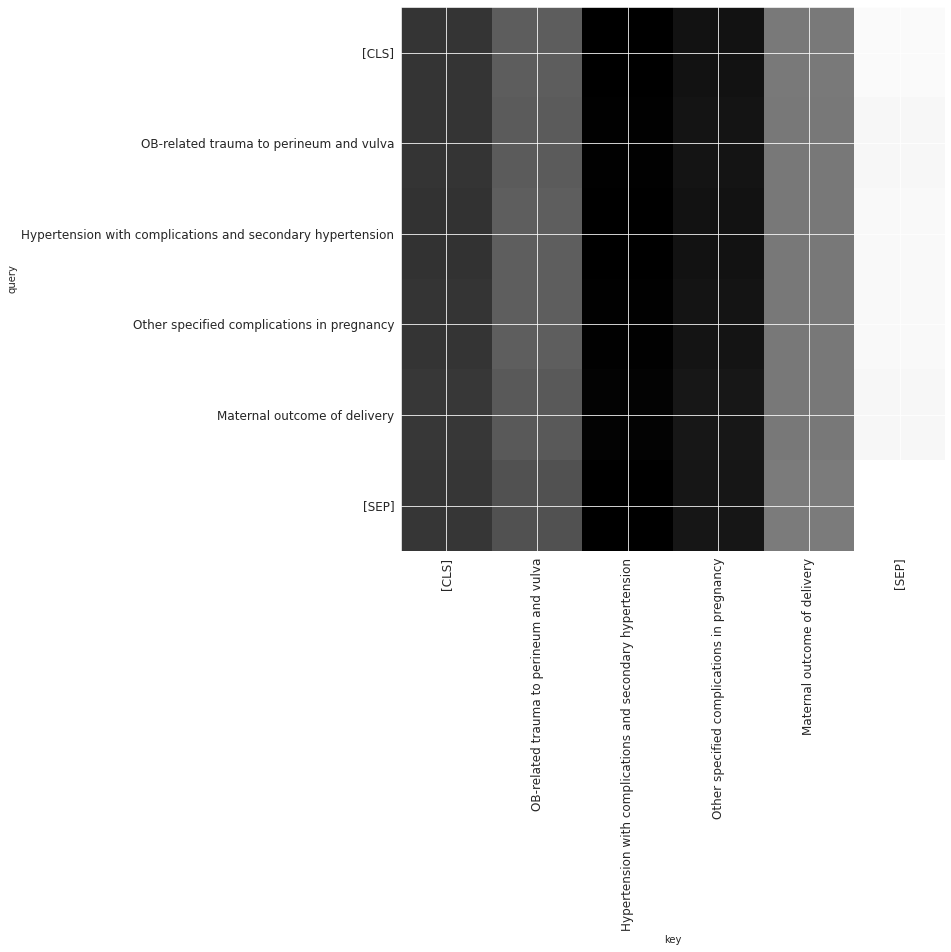

In [374]:
with torch.no_grad():
    model.eval()
    datapoint = next(iterr)
    age, gender, code, position, segment, mask, label, prior_guide, tokens = datapoint

    loss, preds, labels, attention_scores, sequence_outputs = model(code, age_ids=age, gender_ids=gender, seg_ids=segment, posi_ids=position, attention_mask=mask, labels=label, prior_guide=prior_guide)
    sentence = tokenizer.convert_ids_to_tokens(tokens.numpy().squeeze(), 'code')
    lastatt = attention_scores[-1]
    averagedlastatt = ((lastatt.sum(dim=1) / lastatt.shape[1])[0]).detach().numpy()
    
sentence = [mimicdiagcodes[s] if s in mimicdiagcodes else s for s in sentence if s!='[PAD]']
f, ax = plt.subplots(figsize = (10,15))
map1 = lastatt[0][1].detach().numpy() #((layer.sum(dim=1) / layer.shape[1])[0]).detach().numpy()
map1 = map1[:len(sentence), :len(sentence)]
plt.clf()
f=plt.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
i=ax.imshow(map1,interpolation='nearest',cmap='gray')
ax.set_yticks(range(len(sentence)))
ax.set_yticklabels(sentence, fontsize=12)
ax.set_xticks(range(len(sentence)))
ax.set_xticklabels(sentence,rotation=90, fontsize=12)
ax.set_xlabel('key', fontsize=10)
ax.set_ylabel('query', fontsize=10)
ax.grid(linewidth = 0.8)

##### Average Attentions

In [375]:
token_combs = {}
with torch.no_grad():
    model.eval()
    for idx, batch in enumerate(mimicloader):
        if idx == 5000:
            break
        age, gender, code, position, segment, mask, label, prior_guide, tokens = batch
        loss, preds, labels, attention_scores, sequence_outputs = model(code, age_ids=age, gender_ids=gender, seg_ids=segment, posi_ids=position, attention_mask=mask, labels=label, prior_guide=prior_guide)
        sentence = tokenizer.convert_ids_to_tokens(tokens.numpy().squeeze(), 'code')
        #sentences.extend(sentence)
        seq_out = sequence_outputs[-1]
        lastattentionscores = attention_scores[-1]
        
        averagedheads = (lastattentionscores.sum(dim=1) / lastattentionscores.shape[1])[0]
        
        dontlookattokens = set(['[CLS]', '[SEP]', '[PAD]'])
        for idx1, token1 in enumerate(sentence):
            if token1 in dontlookattokens:
                continue
            for idx2, token2 in enumerate(sentence):
                if token2 in dontlookattokens:
                    continue
                comb = token1 + ',' + token2
                prob = averagedheads[idx1, idx2]
                if comb not in token_combs:
                    token_combs[comb] = (prob.item(), 1)
                else:
                    new_prob = prob.item() + token_combs[comb][0]
                    numtimes = token_combs[comb][1] + 1
                    token_combs[comb] = (new_prob, numtimes)
        #seq = torch.cat((seq, seq_out), 0)

In [377]:
from operator import itemgetter
finalcombs = dict([(k, v / n) for k, (v, n) in token_combs.items()])
N = 10
res = dict(sorted(finalcombs.items(), key = itemgetter(1), reverse = True)[:N])

newrep = {'Condition1':[], 'Condition2':[], 'Attention': []}
for key, prob in res.items():
    code1, code2 = key.split(',')
    code1desc = mimicdiagcodes[code1]
    code2desc = mimicdiagcodes[code2]
    newrep['Condition1'].append(code1desc)
    newrep['Condition2'].append(code2desc)
    newrep['Attention'].append(prob)
df = pd.DataFrame(newrep)
fig = go.Figure(data=[go.Table(
  header=dict(
    values=["<b>Condition1</b>", "<b>Condition2</b>", "<b>Attention</b>"],
    line_color='white', fill_color='white',
    align='center', font=dict(color='black', size=12)
  ),
  cells=dict(
    values=[df.Condition1, df.Condition2, df.Attention],
    align='center', font=dict(color='black', size=11)
  ))
])

fig.show()